In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.feature_selection import SelectKBest, mutual_info_regression, RFECV
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import ast

In [2]:
df = pd.read_csv("CleanData.csv", parse_dates=True)
df

,Ward Name,Street Name,Longitude,Latitude,Area (m²),Width (m),Length (m),Legal Status,House Direction,Floors,Rooms,Toilets,Furnishing Sell,Price
0,Quận Cẩm Lệ,Đường Cách Mạng Tháng Tám,108.198830,16.014187,65.0,5.0,13.0,1,3.0,2.0,3,2.0,4.0,2650000
1,Quận Cẩm Lệ,Kiêt Cách Mạng Tháng 8 TP Đà Nẵng,108.199200,16.012283,65.0,5.0,12.0,1,6.0,2.0,3,3.0,2.0,2950000
2,Quận Ngũ Hành Sơn,Chế Lan Viên,108.245480,16.042667,90.0,5.0,21.0,1,4.0,5.0,9,7.0,1.0,70000000
3,Quận Liên Chiểu,Đường Trần Đức,108.153984,16.046675,75.0,5.0,15.0,4,7.0,1.0,2,1.0,1.0,440000000
4,Quận Cẩm Lệ,Khe cạn,108.175480,16.048260,80.0,5.0,20.0,5,6.0,1.0,1,1.0,4.0,450000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4117,Quận Sơn Trà,Đường Vũ Đình Long,108.247505,16.094849,85.0,5.0,17.0,1,8.0,2.0,3,2.0,2.0,5300000000
4118,Quận Liên Chiểu,Đường Hòa Minh 22,108.161545,16.078089,80.0,5.0,16.0,1,6.0,3.0,4,5.0,1.0,5500000000
4119,Huyện Hòa Vang,Đường An Ngãi,108.100586,16.062296,178.1,5.0,21.0,1,6.0,2.0,3,2.0,2.0,6200000000
4120,Quận Sơn Trà,Đường Ngô Quyền,108.240730,16.086813,100.0,5.0,20.0,1,8.0,2.0,3,2.0,2.0,7500000000


In [3]:
def convert_to_list(value):
    if isinstance(value, str): 
        try:
            return ast.literal_eval(value)  
        except:
            return [value.strip()]  
    elif isinstance(value, list):
        return value 
    else:
        return [] 

### One-hot encoding 

In [4]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

encoded_columns = encoder.fit_transform(df[["Ward Name", "Street Name"]])
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(["Ward Name", "Street Name"]))

df = df.drop(columns=["Ward Name", "Street Name"]).join(encoded_df)

df.head()

,Longitude,Latitude,Area (m²),Width (m),Length (m),Legal Status,House Direction,Floors,Rooms,Toilets,...,Street Name_Đồng Trí 4,Street Name_Đồng Xoài,Street Name_Đỗ Quang,Street Name_Đỗ Thúc Tịnh,Street Name_Đỗ Đình Thiện,Street Name_điện biên phủ,Street Name_đại la 4,Street Name_đảo nổi,Street Name_đồng bài 2,Street Name_đồng xoài
0,108.198830,16.014187,65.0,5.0,13.0,1,3.0,2.0,3,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,108.199200,16.012283,65.0,5.0,12.0,1,6.0,2.0,3,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,108.245480,16.042667,90.0,5.0,21.0,1,4.0,5.0,9,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,108.153984,16.046675,75.0,5.0,15.0,4,7.0,1.0,2,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,108.175480,16.048260,80.0,5.0,20.0,5,6.0,1.0,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Feature Transformation

### Normalize using Arcsine method

In [5]:
columns_to_asinh = ["Price", "Longitude", "Latitude", "Area (m²)", "Width (m)", "Length (m)", "Floors", "Rooms", "Toilets"]
df_asinh_transformed = df.copy()
df_asinh_transformed[columns_to_asinh] = np.arcsinh(df_asinh_transformed[columns_to_asinh])
df_asinh_transformed[columns_to_asinh].head()

,Price,Longitude,Latitude,Area (m²),Width (m),Length (m),Floors,Rooms,Toilets
0,15.483217,5.377139,3.467596,4.867594,2.312438,3.259573,1.443635,1.818446,1.443635
1,15.590463,5.377143,3.467477,4.867594,2.312438,3.179785,1.443635,1.818446,1.818446
2,18.757153,5.377570,3.469369,5.192988,2.312438,3.738236,2.312438,2.893444,2.644121
3,20.595432,5.376725,3.469618,5.010680,2.312438,3.402307,0.881374,1.443635,0.881374
4,20.617905,5.376923,3.469717,5.075213,2.312438,3.689504,0.881374,0.881374,0.881374


### Normalization using Z-score method

In [6]:
columns_to_zScore = ["Price", "Longitude", "Latitude", "Area (m²)", "Width (m)", "Length (m)", "Floors", "Rooms", "Toilets"]
std_scaler_zScore = StandardScaler()
df_std_scaled_zScore = std_scaler_zScore.fit_transform(df[columns_to_zScore])
df_std_scaled_zScore = pd.DataFrame(df_std_scaled_zScore, columns=columns_to_zScore)
df_std_scaled_zScore[columns_to_zScore].head()

,Price,Longitude,Latitude,Area (m²),Width (m),Length (m),Floors,Rooms,Toilets
0,-1.467406,-0.231732,-1.211258,-0.583696,0.0,-0.647076,-0.282931,-0.169665,-0.494965
1,-1.467329,-0.220298,-1.274591,-0.583696,0.0,-0.815934,-0.282931,-0.169665,0.228014
2,-1.449948,1.209909,-0.263928,0.043569,0.0,0.703785,2.467642,3.383381,3.119928
3,-1.354036,-1.617623,-0.130610,-0.332790,0.0,-0.309361,-1.199789,-0.761839,-1.217944
4,-1.351444,-0.953325,-0.077888,-0.207337,0.0,0.534928,-1.199789,-1.354013,-1.217944


### Normalize using Logarithmic method

In [7]:
columns_to_log = ["Price", "Longitude", "Latitude", "Area (m²)", "Width (m)", "Length (m)", "Floors", "Rooms", "Toilets"]
df_log_transformed = df.copy()
df_log_transformed = df[columns_to_log].apply(np.log1p)
df_log_transformed = pd.DataFrame(df_log_transformed, columns=columns_to_log)
df_log_transformed[columns_to_log].head()

,Price,Longitude,Latitude,Area (m²),Width (m),Length (m),Floors,Rooms,Toilets
0,14.790071,4.693170,2.834048,4.189655,1.791759,2.639057,1.098612,1.386294,1.098612
1,14.897316,4.693174,2.833936,4.189655,1.791759,2.564949,1.098612,1.386294,1.386294
2,18.064006,4.693597,2.835720,4.510860,1.791759,3.091042,1.791759,2.302585,2.079442
3,19.902285,4.692760,2.835955,4.330733,1.791759,2.772589,0.693147,1.098612,0.693147
4,19.924758,4.692956,2.836048,4.394449,1.791759,3.044522,0.693147,0.693147,0.693147


### Normalize using square root method

In [8]:
columns_to_sqrt = ["Price", "Longitude", "Latitude", "Area (m²)", "Width (m)", "Length (m)", "Floors", "Rooms", "Toilets"]
df_sqrt_transformed = df.copy()
df_sqrt_transformed = df[columns_to_sqrt].apply(np.sqrt)
df_sqrt_transformed = pd.DataFrame(df_sqrt_transformed, columns=columns_to_sqrt)
df_sqrt_transformed[columns_to_sqrt].head()

,Price,Longitude,Latitude,Area (m²),Width (m),Length (m),Floors,Rooms,Toilets
0,1627.882060,10.401867,4.001773,8.062258,2.236068,3.605551,1.414214,1.732051,1.414214
1,1717.556404,10.401884,4.001535,8.062258,2.236068,3.464102,1.414214,1.732051,1.732051
2,8366.600265,10.404109,4.005330,9.486833,2.236068,4.582576,2.236068,3.000000,2.645751
3,20976.176963,10.399711,4.005830,8.660254,2.236068,3.872983,1.000000,1.414214,1.000000
4,21213.203436,10.400744,4.006028,8.944272,2.236068,4.472136,1.000000,1.000000,1.000000


### Data verification

*Histogram comparing the variable Price before and after normalization*

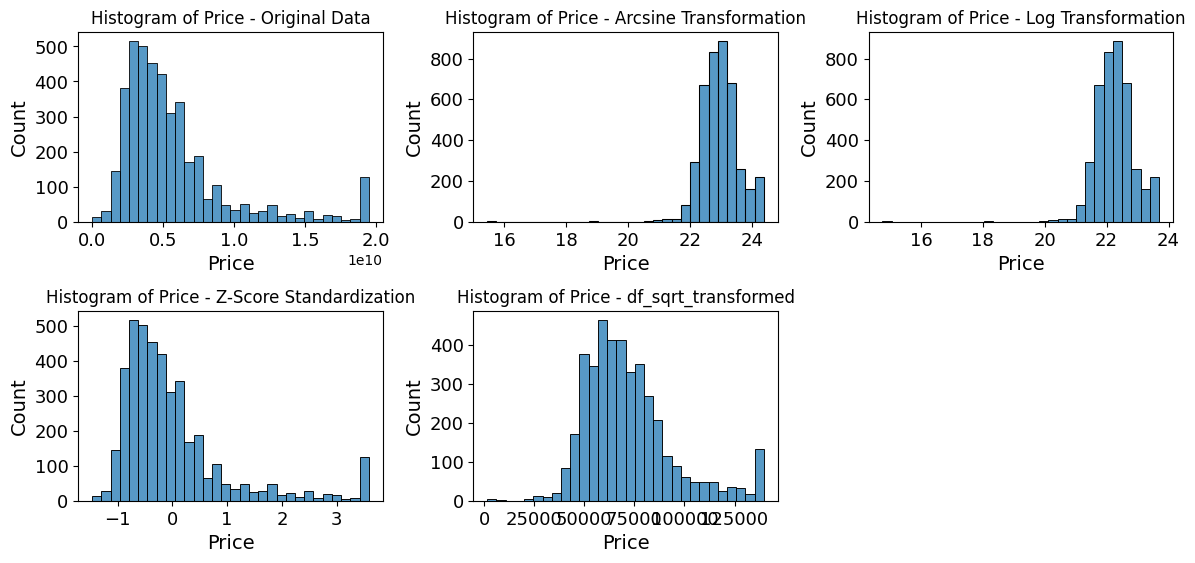

In [9]:
dfs = [df, df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", 'Arcsine Transformation', 'Log Transformation', 'Z-Score Standardization', 'df_sqrt_transformed']
plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    sns.histplot(data=data['Price'], bins=30)
    plt.ylabel('Count', fontsize = 14)
    plt.xlabel('Price', fontsize = 14)
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.title(f'Histogram of Price - {method}')
    plt.tight_layout()

plt.show()

*Histogram comparing the variable Area (m²) before and after normalization*

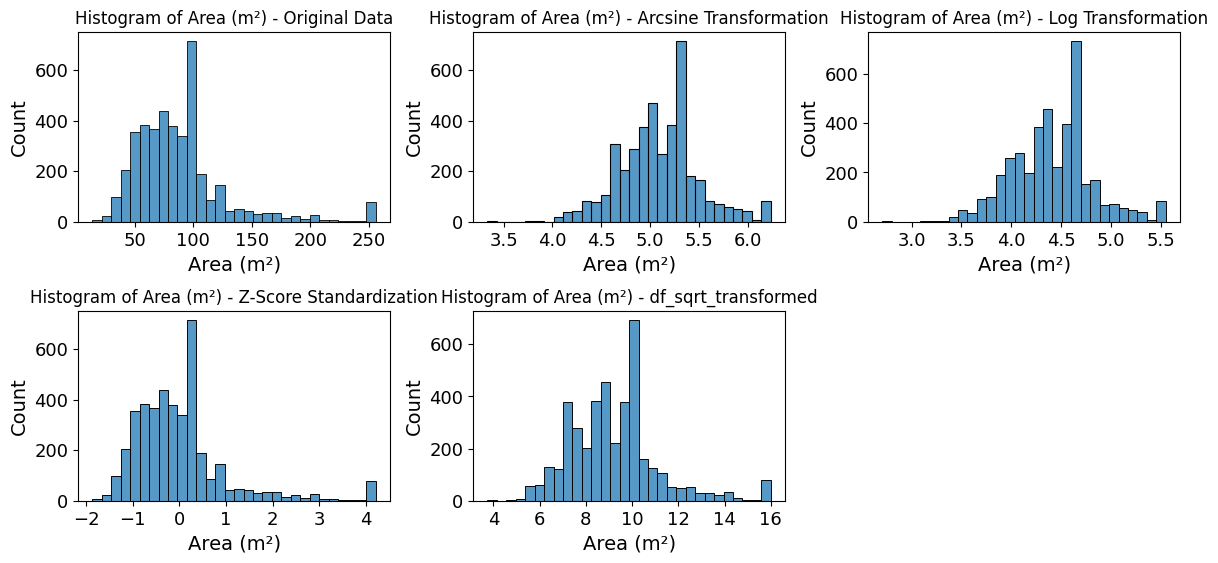

In [10]:
dfs = [df, df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", 'Arcsine Transformation', 'Log Transformation', 'Z-Score Standardization', 'df_sqrt_transformed']
plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    sns.histplot(data=data['Area (m²)'], bins=30)
    plt.ylabel('Count', fontsize = 14)
    plt.xlabel('Area (m²)', fontsize = 14)
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.title(f'Histogram of Area (m²) - {method}')
    plt.tight_layout()

plt.show()

*Use probability graph to verify whether the transformed data follows the normal distribution*

- Comparison of the distribution of the *Price* feature when applying normalization methods

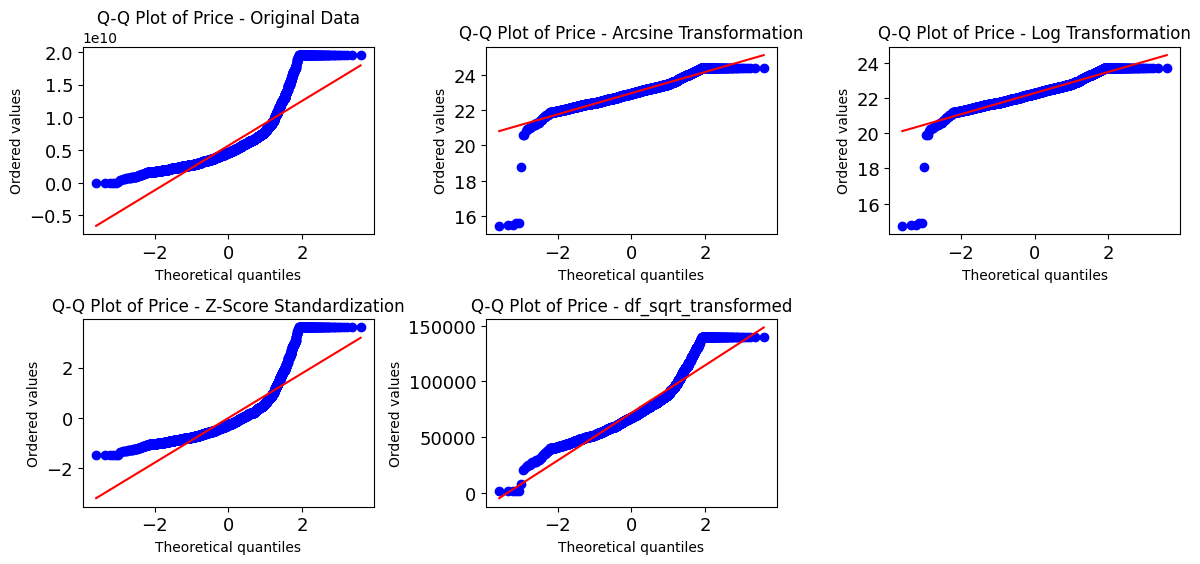

In [11]:
dfs = [df,df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", 'Arcsine Transformation', 'Log Transformation', 'Z-Score Standardization', 'df_sqrt_transformed']

plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    stats.probplot(data['Price'], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Price - {method}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

- Comparison of the distribution of the *Area (m²)* feature when applying normalization methods

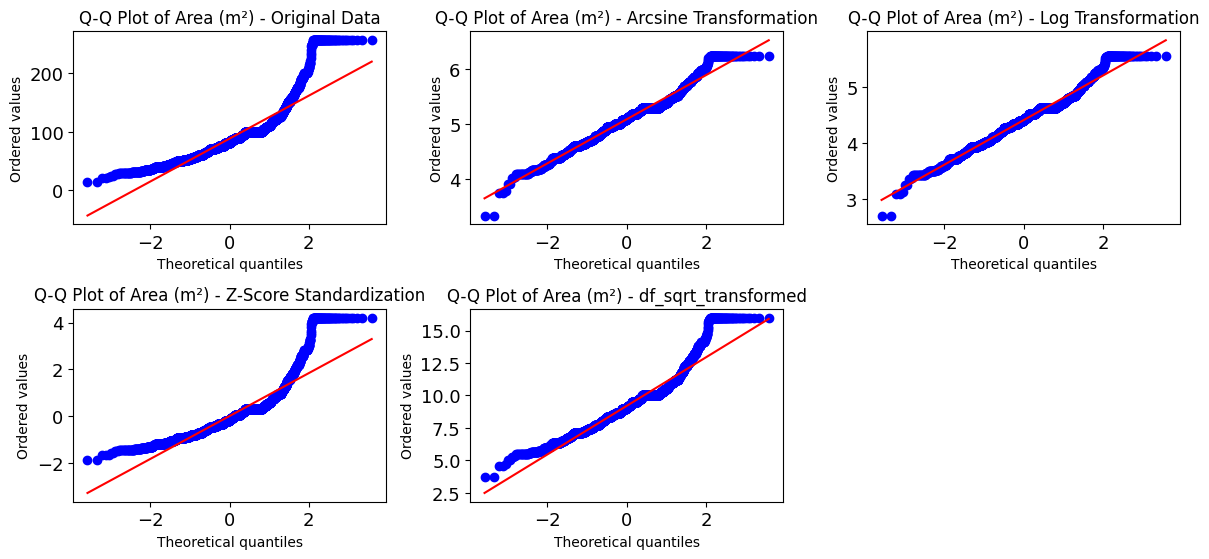

In [12]:
dfs = [df,df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", 'Arcsine Transformation', 'Log Transformation', 'Z-Score Standardization', 'df_sqrt_transformed']

plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    stats.probplot(data['Area (m²)'], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Area (m²) - {method}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

- Comparison of the distribution of the *Width (m)* feature when applying normalization methods

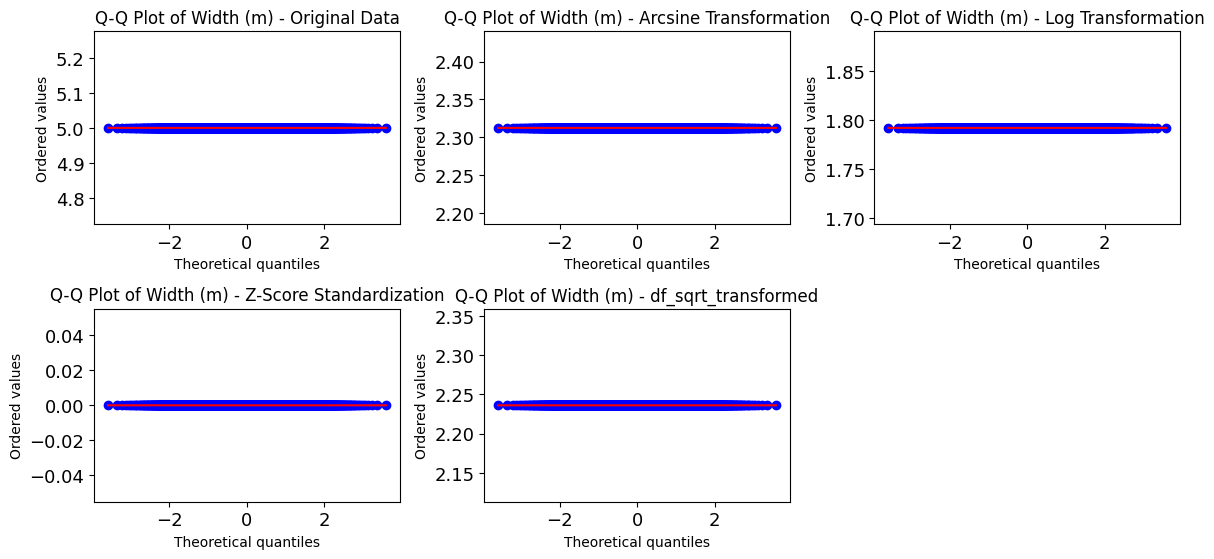

In [13]:
dfs = [df,  df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", 'Arcsine Transformation', 'Log Transformation', 'Z-Score Standardization', 'df_sqrt_transformed']

plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    stats.probplot(data['Width (m)'], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Width (m) - {method}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

- Comparison of the distribution of the *Longitude* feature when applying normalization methods

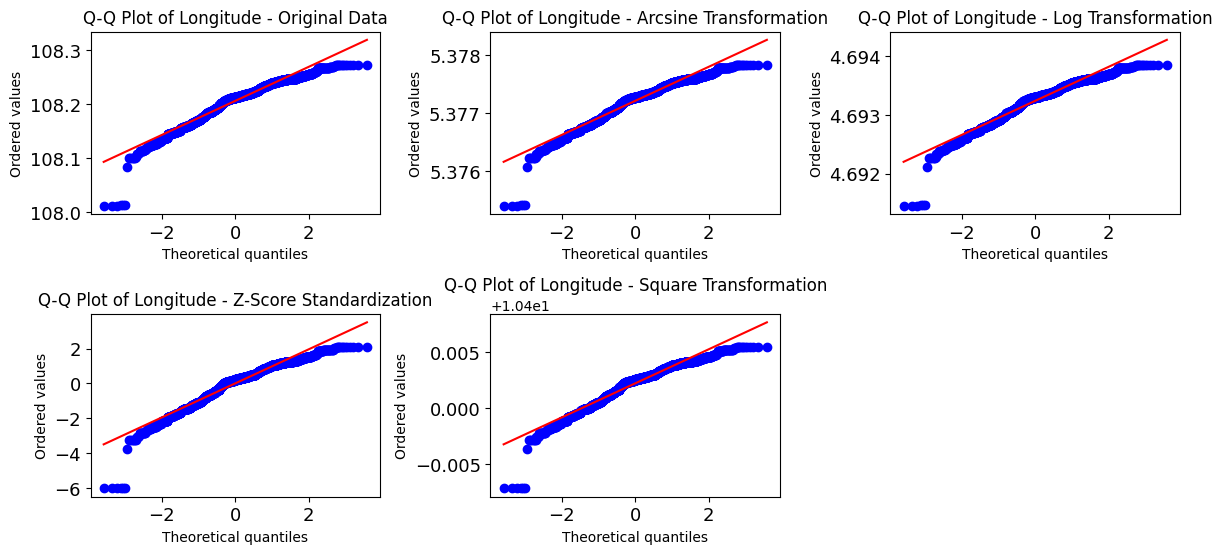

In [14]:
dfs = [df,  df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", 'Arcsine Transformation', 'Log Transformation', 'Z-Score Standardization', 'Square Transformation']

plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    stats.probplot(data['Longitude'], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Longitude - {method}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

- Comparison of the distribution of the *Latitude* feature when applying normalization methods

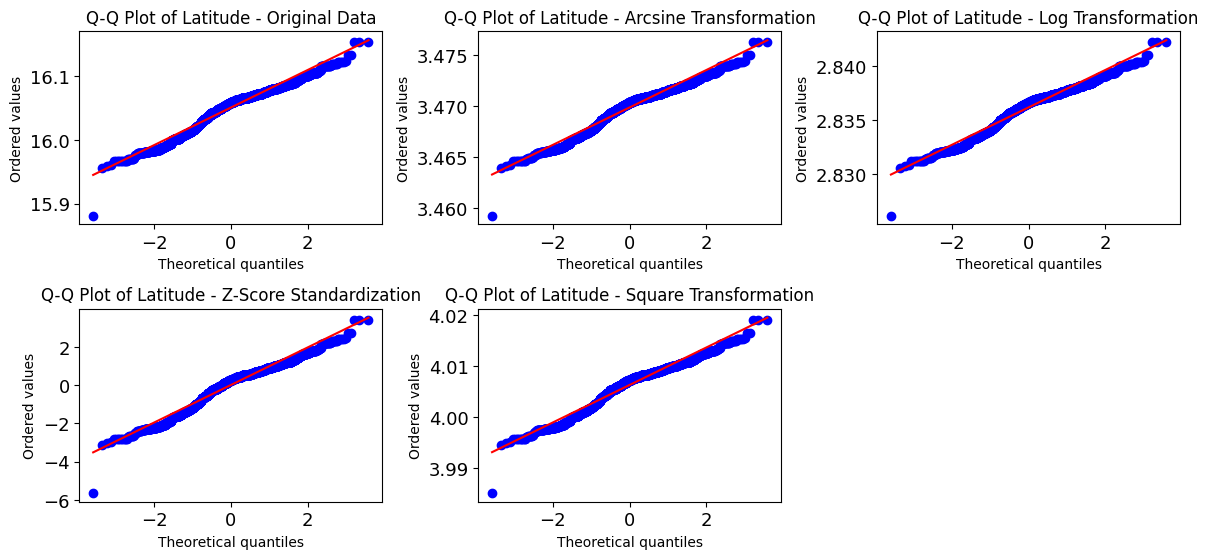

In [15]:
dfs = [df, df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", 'Arcsine Transformation', 'Log Transformation', 'Z-Score Standardization', 'Square Transformation']

plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    stats.probplot(data['Latitude'], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Latitude - {method}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

- Compares distribution of characteristics *Floors* when applying standardized methods

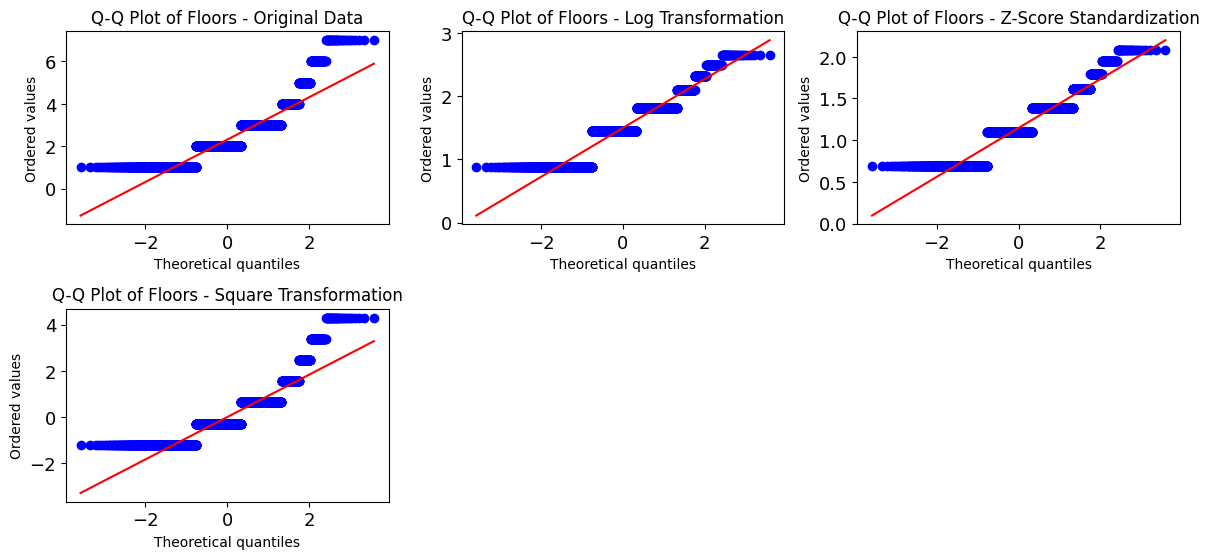

In [16]:
dfs = [df, df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", 'Log Transformation', 'Z-Score Standardization', 'Square Transformation']

plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    stats.probplot(data["Floors"], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Floors - {method}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

- Compares distribution of characteristics *Rooms* when applying standardized methods

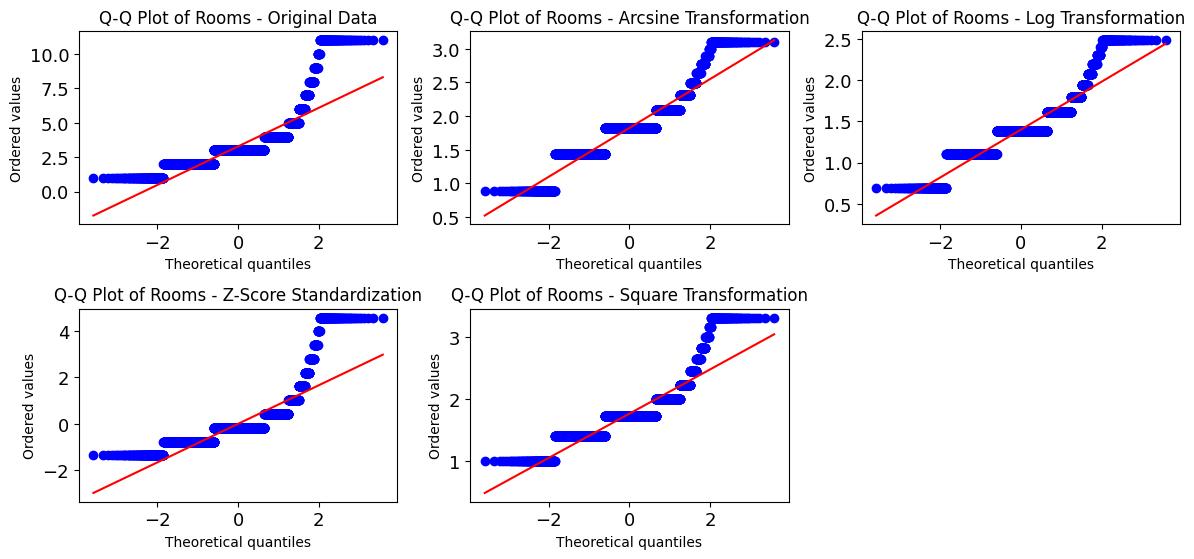

In [17]:
dfs = [df, df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data",'Arcsine Transformation', 'Log Transformation', 'Z-Score Standardization', 'Square Transformation']

plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    stats.probplot(data["Rooms"], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Rooms - {method}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

- Compares distribution of characteristics *Toilets* when applying standardized methods

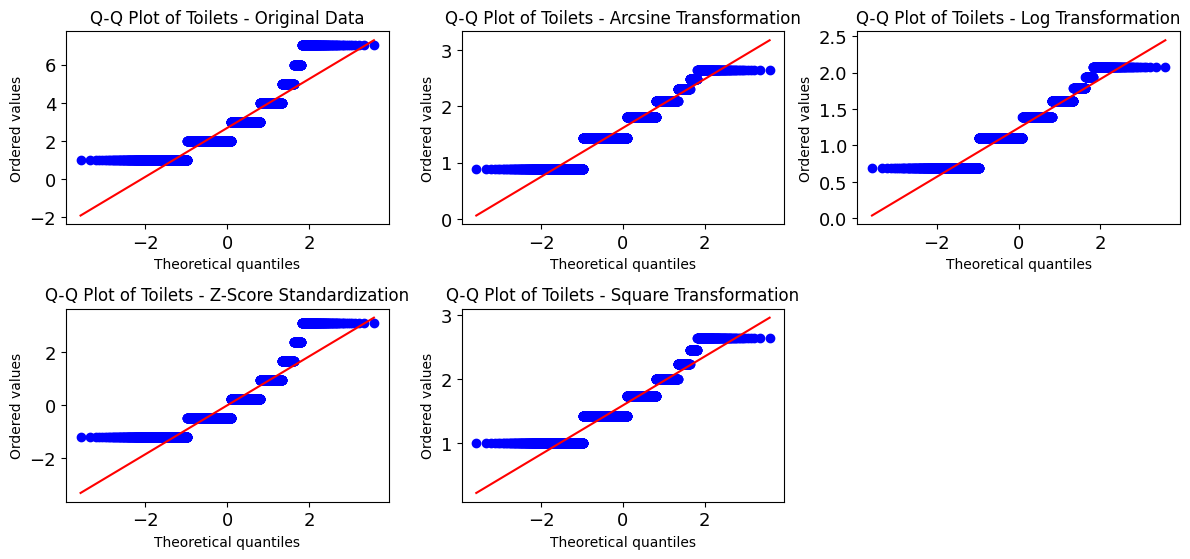

In [18]:
dfs = [df, df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", "Arcsine Transformation", "Log Transformation", "Z-Score Standardization", "Square Transformation"]

plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    stats.probplot(data["Toilets"], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Toilets - {method}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

*The characteristic that follows the most normal distribution is standardized by the square root method.*

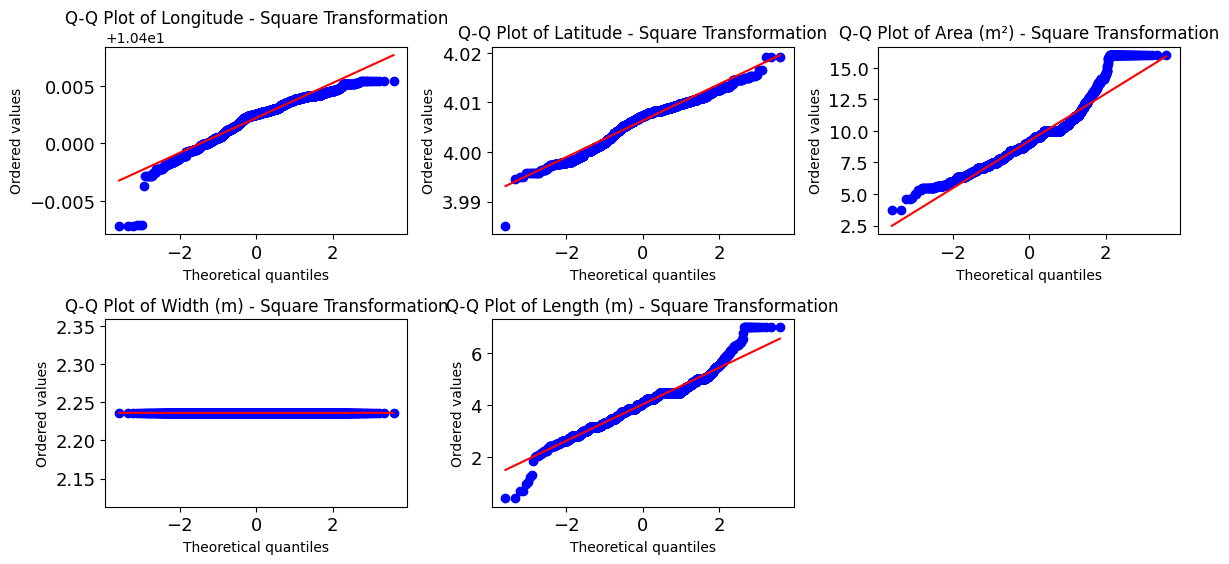

In [19]:
cols = ["Longitude", "Latitude", "Area (m²)", "Width (m)", "Length (m)"]

plt.figure(figsize=(12, 8))
for i, col in enumerate(cols, 1):
    plt.subplot(3, 3, i) 
    stats.probplot(df_sqrt_transformed[col], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of {col} - Square Transformation")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

- Compares distribution of characteristics *Length (m)* when applying standardized methods

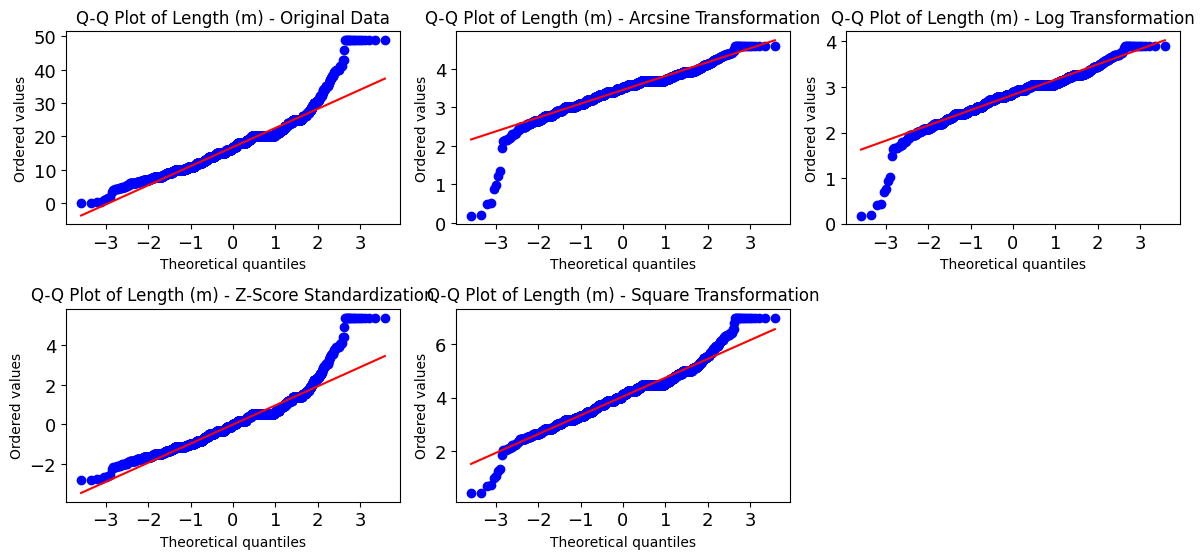

In [20]:
dfs = [df, df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", "Arcsine Transformation", "Log Transformation", "Z-Score Standardization", "Square Transformation"]

plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    stats.probplot(data["Length (m)"], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Length (m) - {method}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

=> Select *Z-Score normalization* method for feature *Length (m)* & *Price*, feature *Rooms* is selected using the *Arcsinh* method to normalize the data. and *Square root* method for features *Longitude, Latitude, Area (m²), Width (m), Floors, Toilets*

In [21]:
df_final = df.copy()

df_final["Length (m)"] = df_std_scaled_zScore["Length (m)"]
df_final["Price"] = df_std_scaled_zScore["Price"]
df_final["Rooms"] =df_asinh_transformed["Rooms"]
columns_sqrt = ["Longitude", "Latitude", "Area (m²)", "Width (m)", "Floors", "Toilets"]
df_final[columns_sqrt] = df_sqrt_transformed[columns_sqrt]

df_final.head()


,Longitude,Latitude,Area (m²),Width (m),Length (m),Legal Status,House Direction,Floors,Rooms,Toilets,...,Street Name_Đồng Trí 4,Street Name_Đồng Xoài,Street Name_Đỗ Quang,Street Name_Đỗ Thúc Tịnh,Street Name_Đỗ Đình Thiện,Street Name_điện biên phủ,Street Name_đại la 4,Street Name_đảo nổi,Street Name_đồng bài 2,Street Name_đồng xoài
0,10.401867,4.001773,8.062258,2.236068,-0.647076,1,3.0,1.414214,1.818446,1.414214,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10.401884,4.001535,8.062258,2.236068,-0.815934,1,6.0,1.414214,1.818446,1.732051,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10.404109,4.005330,9.486833,2.236068,0.703785,1,4.0,2.236068,2.893444,2.645751,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10.399711,4.005830,8.660254,2.236068,-0.309361,4,7.0,1.000000,1.443635,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10.400744,4.006028,8.944272,2.236068,0.534928,5,6.0,1.000000,0.881374,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


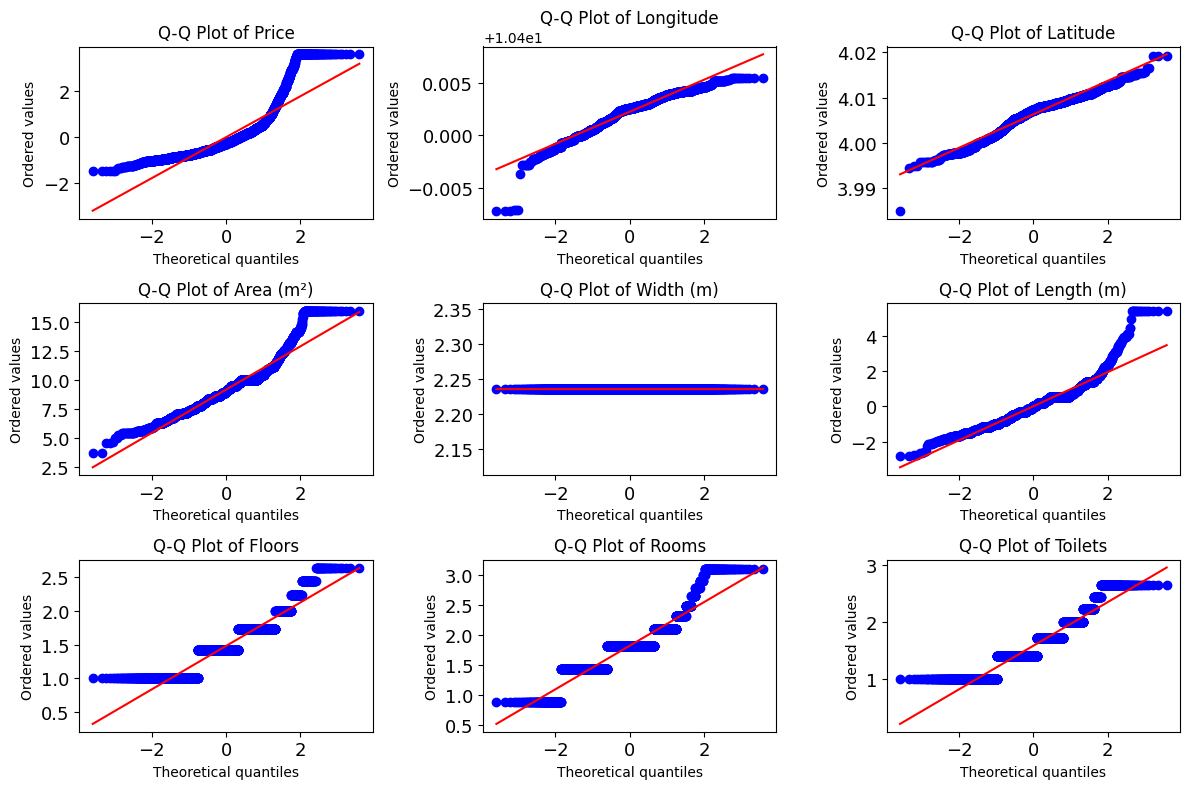

In [22]:
cols = ["Price", "Longitude", "Latitude", "Area (m²)", "Width (m)", "Length (m)", "Floors", "Rooms", "Toilets"]

plt.figure(figsize=(12, 8))
for i, col in enumerate(cols, 1):
    plt.subplot(3, 3, i) 
    stats.probplot(df_final[col], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of {col}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

In [23]:
df_final.to_csv('TransformedData.csv', index=False)
print("DataFrame exported to CSV file.")

DataFrame exported to CSV file.
